#### BANKING: DIRECT MARKETING CASE STUDY (CAMPAIGN RESPONSE MODEL) - CLASSIFICATION MODEL

**OBJECTIVE:** This example uses data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no').

##### Bank client data:
- age (numeric)
- job: type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
- marital: marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
- loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

##### Related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular', 'telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)     
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)


##### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques.

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/BankMarketingDataSet.html


### import the packages and the data

In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns

In [3]:
# Load the data
data = pd.read_csv('D:/Sampledata/bank-additional.csv', sep = ";")

### UDF's

In [4]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [7]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [8]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize = (5, 3))
    sns.countplot(y = pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

### data inspection

In [9]:
# meta data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 675.9+ KB


In [10]:
# create pandas profiling report
profilereport = pandas_profiling.ProfileReport(data)
profilereport.to_file('profilereport.html')

In [11]:
# summaries of continuous variables    
data.select_dtypes(['float64', 'int64']).apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,4119.0,0.0,1.652280e+05,40.113620,38.000,10.313362,106.365426,18.000,24.000,26.0000,28.800,32.000,38.000,47.000,55.000,58.000,68.000,88.000
duration,4119.0,0.0,1.057710e+06,256.788055,181.000,254.703736,64873.993194,0.000,11.000,35.0000,60.000,103.000,181.000,317.000,545.200,740.200,1231.660,3643.000
campaign,4119.0,0.0,1.045100e+04,2.537266,2.000,2.568159,6.595442,1.000,1.000,1.0000,1.000,1.000,2.000,3.000,5.000,7.000,13.000,35.000
pdays,4119.0,0.0,3.955979e+06,960.422190,999.000,191.922786,36834.355710,0.000,3.000,999.0000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000
previous,4119.0,0.0,7.840000e+02,0.190337,0.000,0.541788,0.293535,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,1.000,1.000,3.000,6.000
emp.var.rate,4119.0,0.0,3.500000e+02,0.084972,1.100,1.563114,2.443327,-3.400,-3.400,-2.9000,-1.800,-1.800,1.100,1.400,1.400,1.400,1.400,1.400
cons.price.idx,4119.0,0.0,3.854548e+05,93.579704,93.749,0.579349,0.335645,92.201,92.201,92.7130,92.893,93.075,93.749,93.994,94.465,94.465,94.601,94.767
cons.conf.idx,4119.0,0.0,-1.668158e+05,-40.499102,-41.800,4.594578,21.110142,-50.800,-50.000,-47.1000,-46.200,-42.700,-41.800,-36.400,-36.100,-33.600,-26.900,-26.900
euribor3m,4119.0,0.0,1.491636e+04,3.621356,4.857,1.733591,3.005339,0.635,0.677,0.8084,1.029,1.334,4.857,4.961,4.964,4.966,4.968,5.045
nr.employed,4119.0,0.0,2.128074e+07,5166.481695,5191.000,73.667904,5426.960015,4963.600,4963.600,5008.7000,5076.200,5099.100,5191.000,5228.100,5228.100,5228.100,5228.100,5228.100


In [12]:
# summaries of object variables
data.select_dtypes(['object']).apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
job,4119,0,admin.,1012,24.57
marital,4119,0,married,2509,60.91
education,4119,0,university.degree,1264,30.69
default,4119,0,no,3315,80.48
housing,4119,0,yes,2175,52.8
loan,4119,0,no,3349,81.31
contact,4119,0,cellular,2652,64.38
month,4119,0,may,1378,33.45
day_of_week,4119,0,thu,860,20.88
poutcome,4119,0,nonexistent,3523,85.53


In [13]:
# Labelling y column to 1, 0 values which is orginally stored as yes,no
data['y'] = data['y'].str.lower().replace({'yes': 1, 'no': 0})

In [14]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


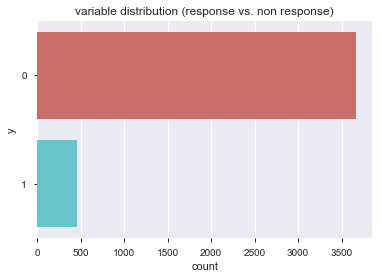

In [15]:
# variable distribution (response vs. non response)
sns.countplot(y = data.y, palette = 'hls')
plt.title('variable distribution (response vs. non response)')
plt.show()

This is a freq chart for job


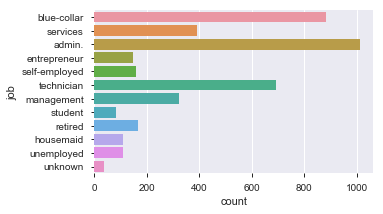

This is a freq chart for marital


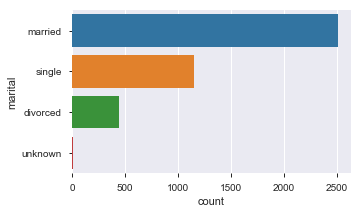

This is a freq chart for education


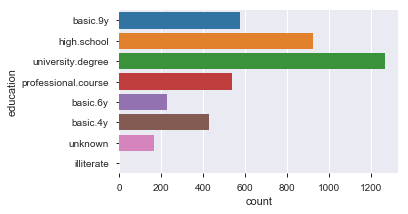

This is a freq chart for default


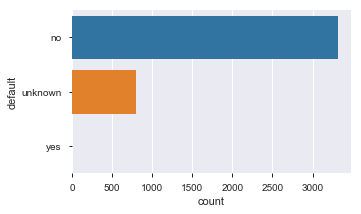

This is a freq chart for housing


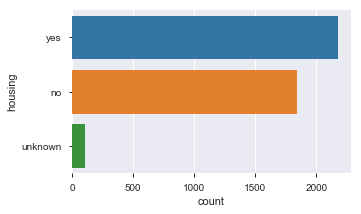

This is a freq chart for loan


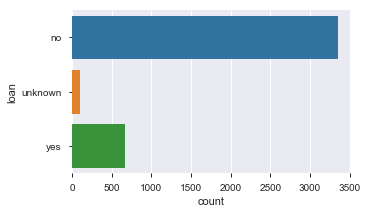

This is a freq chart for contact


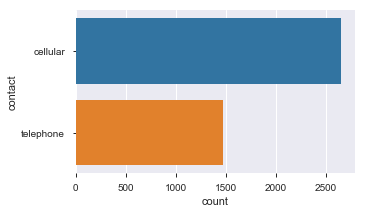

This is a freq chart for month


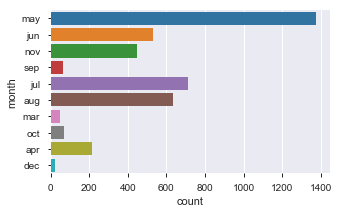

This is a freq chart for day_of_week


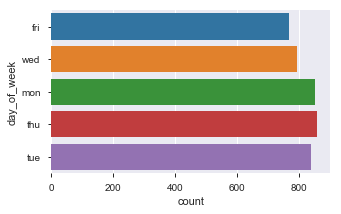

This is a freq chart for poutcome


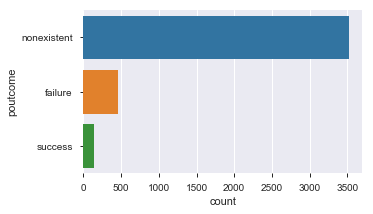

In [16]:
# distribution/freq plot for categorical variables
data.select_dtypes(['object']).apply(fn_countplot)
plt.show()

In [17]:
# mean of all continuous variables by dependent variable y
data.groupby('y').mean().round(2).reset_index()

,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,39.90,219.41,2.61,982.76,0.14,0.24,93.60,-40.59,3.80,5175.50
1,1,41.89,560.79,1.98,778.72,0.59,-1.18,93.42,-39.79,2.15,5093.12


##### Observations:
- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [18]:
# get the dummy variables
for c_feature in data.select_dtypes(['object']).columns:
    data = create_dummies(data, c_feature)

In [20]:
data.shape

(4119, 54)

In [19]:
data.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutc

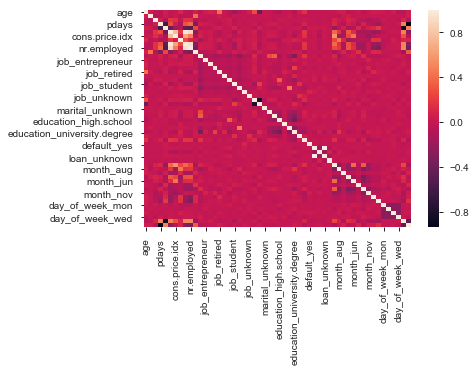

In [21]:
# Check the corr between the variables
sns.heatmap(data.corr())
plt.show()

##### Feature Selection
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [24]:
# import the necessary packages
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [25]:
# get the y and X varaibales
y_var = 'y'
X_var = data.columns.difference(['y'])

In [29]:
# RFE
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
rfe = RFE(logreg, 20)
rfe = rfe.fit(data[X_var], data[y_var])

print(rfe.support_)
print(rfe.ranking_)

[False False False False  True False False False False False False False
 False False False False False False  True False  True  True False  True
  True False  True  True  True  True False False False False  True False
 False False False False  True  True  True  True  True False False  True
 False False  True  True  True]
[30 10 14 16  1 17 34 18  3 27 33 29 12 15  6 25 23 24  1 11  1  1  2  1
  1 28  1  1  1  1 21 20  4 26  1  7  8  9 31 13  1  1  1  1  1  5 19  1
 22 32  1  1  1]


In [33]:
X_final = data[X_var[rfe.support_]]
y_final = data['y']

### build the model

In [35]:
StandardScaler?

In [34]:
# preprocessing the data for standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X_final))
X_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.743752,-0.205565,-1.331707,-0.161736,1.912983,-0.193055,-0.292191,-0.204923,-0.200378,-0.324769,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,1.410360,-0.12563,0.411308,-0.188958,-0.351356
1,1.344534,-0.205565,0.711698,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,3.079110,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,1.410360,-0.12563,0.411308,-0.188958,-0.351356
2,1.344534,-0.205565,0.773427,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,3.079110,-0.161736,-0.073279,-0.456757,2.602249,-0.108585,-0.709039,-0.12563,0.411308,-0.188958,-0.351356
3,1.344534,-0.205565,0.771697,6.182926,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,3.079110,6.182926,-0.073279,-0.456757,2.602249,-0.108585,-0.709039,-0.12563,0.411308,-0.188958,-0.351356
4,-0.743752,-0.205565,0.328632,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,-0.324769,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,-0.12563,0.411308,-0.188958,-0.351356
5,-0.743752,-0.205565,-1.579200,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,3.079110,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,7.95986,-2.431270,-0.188958,3.340571
6,-0.743752,-0.205565,-1.582085,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,-0.324769,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,7.95986,0.411308,-0.188958,-0.351356
7,-0.743752,-0.205565,0.328632,-0.161736,-0.522744,5.179873,-0.292191,-0.204923,-0.200378,-0.324769,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,-0.12563,0.411308,-0.188958,-0.351356
8,-0.743752,-0.205565,0.306709,-0.161736,-0.522744,-0.193055,-0.292191,-0.204923,-0.200378,3.079110,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,-0.709039,-0.12563,-2.431270,-0.188958,1.494607
9,1.344534,-0.205565,0.711698,-0.161736,1.912983,-0.193055,-0.292191,-0.204923,-0.200378,-0.324769,-0.161736,-0.073279,-0.456757,-0.384283,-0.108585,1.410360,-0.12563,0.411308,-0.188958,-0.351356


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_final, 
                                                    test_size = 0.3, random_state = 12345)

### KNN

In [38]:
# import the packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [86]:
KNeighborsClassifier?

In [50]:
#set the tuning parameters (k) for grid search
tuned_parameters = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}

# build the KNN model
knn_clf = GridSearchCV(KNeighborsClassifier(),
                   tuned_parameters,
                   cv = 10,
                   scoring = 'roc_auc')

In [51]:
 # model fit
knn_clf.fit(X_train, y_train)
knn_clf.best_score_

0.7007288393859353

In [52]:
metrics.roc_auc_score( y_train, knn_clf.predict_proba( X_train )[:, 1] )

0.8255519705286061

In [53]:
knn_clf.best_params_

{'n_neighbors': 11}

In [54]:
# re-building the model for the best n_neighbors
knn_clf = KNeighborsClassifier( n_neighbors = 11)
knn_clf.fit( X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [55]:
# confusion matrix
knn_cm = metrics.confusion_matrix( y_test, knn_clf.predict( X_test ))

Text(0.5, 12.5, 'Predicted label')

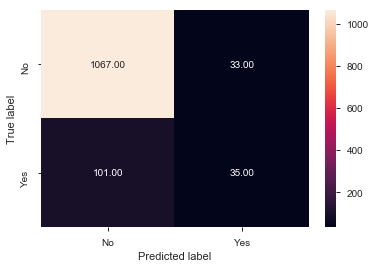

In [56]:
sns.heatmap(knn_cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [57]:
# get the model accuracy
print(metrics.accuracy_score(y_train, knn_clf.predict(X_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.9091224419007978
0.8915857605177994


In [58]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [59]:
# get the model auc
print(metrics.roc_auc_score(y_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.8255519705286061
0.7674866310160426


In [60]:
# Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_clf.predict( X_test )))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1100
           1       0.51      0.26      0.34       136

    accuracy                           0.89      1236
   macro avg       0.71      0.61      0.64      1236
weighted avg       0.87      0.89      0.88      1236



Interpretation: We can see from  poor precion and recall for '1's in classification report and AUC that model performacne is not upto the mark. High accuracy score is misleading because of skewed data.

We will now rebuild the model after re-balancing the data

#### We will now rebuild the model after re-balancing the data. 
Oversampling & Undersampling for imbalance data

In [ ]:
# pip install imblearn

In [61]:
# import the packages
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

#### rebuild model after undersampling

In [78]:
# perform the under sampling
rus = RandomUnderSampler(random_state = 500)
X_res_train, y_res_train = rus.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Undersampled dataset shape {}'.format(Counter(y_res_train)))

Original dataset shape Counter({0: 2568, 1: 315})
Undersampled dataset shape Counter({0: 315, 1: 315})


In [79]:
# rebuild the model after resampling
knn_clf = KNeighborsClassifier( n_neighbors = 11 )

In [80]:
# Refitting the model on under sampled data
knn_clf.fit(X_res_train, y_res_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [81]:
# get the model accuracy
print(metrics.accuracy_score(y_res_train, knn_clf.predict(X_res_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.7238095238095238
0.7799352750809061


In [82]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_res_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [83]:
# get the model auc
print(metrics.roc_auc_score(y_res_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.7991332829428067
0.7706584224598931


In [84]:
# confusion matrix
knn_cm = metrics.confusion_matrix( y_test, knn_clf.predict( X_test ))

In [85]:
knn_cm

array([[877, 223],
       [ 49,  87]], dtype=int64)

#### refit model after over-sampling

In [70]:
# perform the over sampling
ros = RandomOverSampler(random_state = 500)
X_res_train, y_res_train = ros.fit_sample(X_train, y_train)
print('Original dataset shape {}'.format(Counter(y_train)))
print('Oversampled dataset shape {}'.format(Counter(y_res_train)))

Original dataset shape Counter({0: 2568, 1: 315})
Oversampled dataset shape Counter({0: 2568, 1: 2568})


In [71]:
# rebuild the model after resampling
knn_clf = KNeighborsClassifier( n_neighbors = 11 )

In [72]:
# Refitting the model on under sampled data
knn_clf.fit(X_res_train, y_res_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [73]:
# get the model accuracy
print(metrics.accuracy_score(y_res_train, knn_clf.predict(X_res_train)))
print(metrics.accuracy_score(y_test, knn_clf.predict(X_test)))

0.7864096573208723
0.8260517799352751


In [74]:
# get the probability score on training and testing
train_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_res_train))[1]
test_predict_prob = pd.DataFrame(knn_clf.predict_proba(X_test))[1]

In [75]:
# get the model auc
print(metrics.roc_auc_score(y_res_train, train_predict_prob))
print(metrics.roc_auc_score(y_test, test_predict_prob))

0.8637296076319134
0.7836263368983958


In [76]:
# confusion matrix
knn_cm = metrics.confusion_matrix( y_test, knn_clf.predict( X_test ))

In [77]:
knn_cm

array([[934, 166],
       [ 49,  87]], dtype=int64)

The increment of 8 pts in  AUC is quite evidednt of the fact how re-balancing data can improve the model performance. This concept is applicable for all type of classification models and must be considered if the provided data is imbalanced. 